# Deep into Computer Science Publications - Milestone 3
**Applied Data Analysis @ EPFL -** By Nour Ghalia Abbassi, Khalil Cherif, and Aymen Gannouni

In [442]:
import pandas as pd
import pyarrow
import fastparquet
import json
import numpy as np
import seaborn as sns
%matplotlib inline 
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm


## Load complete data 

The data was cleaned in the other ipynb file where we did the scrapping. Here we are only doing the analysis and the clustering.

In [2]:
#load all our dataset
path = '/Users/nourghaliaabassi/Downloads/dblp-ref/dblp-ref-0.json'
doc = []
for i in range(4):
    file = open('/Users/nourghaliaabassi/Downloads/dblp-ref/dblp-ref-'+str(i)+'.json') 
    for line in file:
        j_content = json.loads(line)
        doc.append(j_content)
doc = pd.DataFrame(doc)

In [4]:
#load the page_rank algorithm applied to our publications
page_rank = pd.read_parquet('/Users/nourghaliaabassi/Downloads/final_page_rank')

In [314]:
#append the pagerank results to our dataframe and sort it depending on the pagerank score
page_rank_df = doc.merge(page_rank, on = 'id')
page_rank_df.sort_values(by = 'pagerank', ascending=False, inplace = True)

In [349]:
page_rank_df.head()

,abstract,authors,id,references,title,venue,year,pagerank
1437201,Finite automata are considered in this paper a...,"[Michael O. Rabin, Dana S. Scott]",b0f6455a-6f99-42c5-8502-4fa535768ceb,[1cecb6af-a150-4abe-a950-6ceab75d015f],Finite automata and their decision problems,Ibm Journal of Research and Development,1959,2018.186268
804326,"Rabin has proved1,2 that two-way finite automa...",[J. C. Shepherdson],1cecb6af-a150-4abe-a950-6ceab75d015f,[b0f6455a-6f99-42c5-8502-4fa535768ceb],The reduction of two-way automata to one-way a...,Ibm Journal of Research and Development,1959,1820.104506
557560,"From the Publisher:#R##N#With this text, you g...","[Alfred V. Aho, John E. Hopcroft]",a662a4e7-415e-417e-8a8f-fe085d7e487f,[],The Design and Analysis of Computer Algorithms,,1974,1396.062942
1283932,It is shown that any recognition problem solve...,[Stephen A. Cook],8d09527f-b5ad-4902-ba34-5583f6759d3b,"[c0a69970-4b14-492a-adcc-6928988a9f2a, c5dbdb9...",The complexity of theorem-proving procedures,symposium on the theory of computing,1971,1364.043082
2384088,Two kinds of contemporary developments in cryp...,"[Whitfield Diffie, Martin E. Hellman]",ca394e6a-59e0-466c-a66a-d976555db689,"[172f9f68-8417-43bb-8fe5-b377d569f6b6, 360dc1b...",New Directions in Cryptography,IEEE Transactions on Information Theory,1976,1238.157584


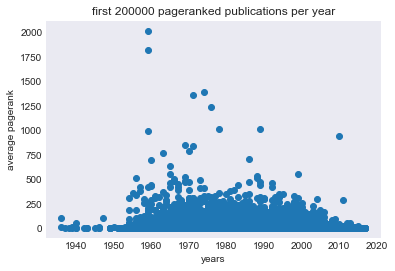

In [320]:
#plot the first 200000 publication/years that have the best pagerank
plt.title('first 200000 pageranked publications per year')
plt.xlabel('years')
plt.ylabel('average pagerank')
fig = plt.scatter(x =page_rank_df[:200000]['year'], y = page_rank_df[:200000]['pagerank'])

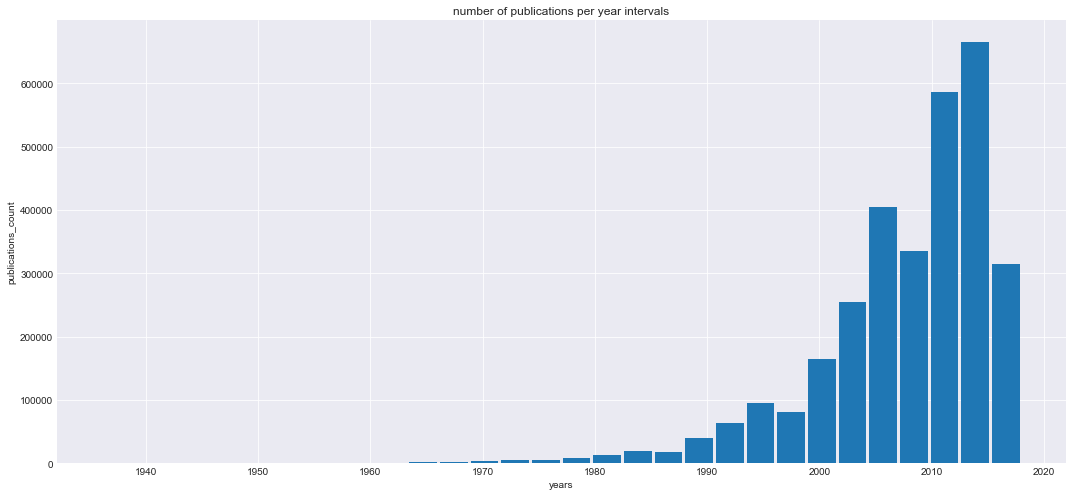

In [265]:
# number of publications per year
page_rank_df.hist(column='year',bins = 30, label= 'year', rwidth= 0.9,figsize=[15,7])
plt.title('number of publications per year intervals')
plt.xlabel('years')
plt.ylabel('publications_count')
plt.tight_layout()

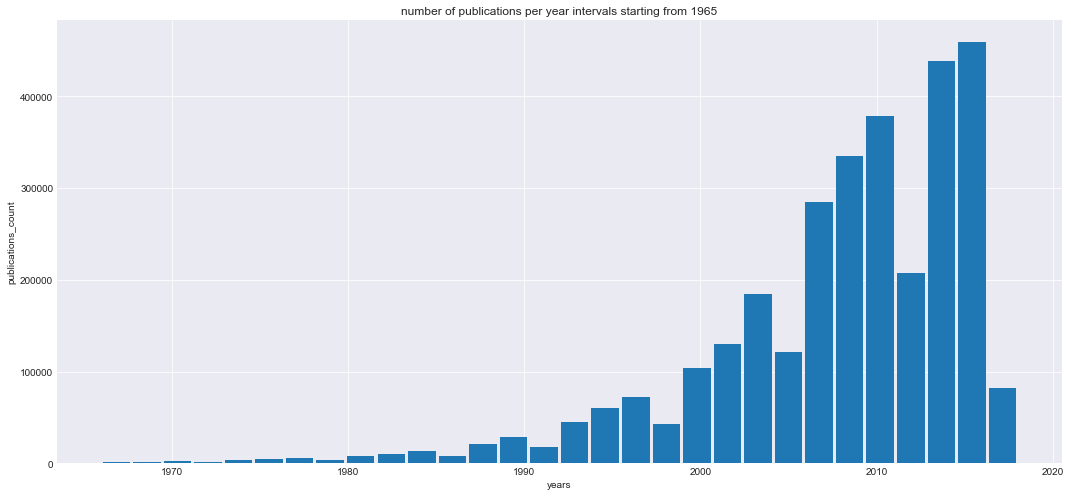

In [332]:
# zoom on the number of publications per year starting from 1965
page_rank_df[page_rank_df['year']>1965].hist(column='year',bins = 30, label= 'year', rwidth= 0.9,figsize=[15,7])
plt.title('number of publications per year intervals starting from 1965')
plt.xlabel('years')
plt.ylabel('publications_count')
plt.tight_layout()

In [281]:
#calculating the average pagerank per year
average_year_PR = page_rank_df.groupby(by ='year').mean().sort_values(by = 'pagerank', ascending = False).reset_index()

In [282]:
average_year_PR.head()

,year,pagerank
0,1959,36.536994
1,1947,27.194903
2,1936,17.504742
3,1960,16.156488
4,1956,15.550937


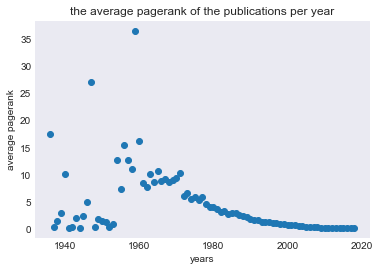

In [312]:
#plotting the average pagerank per year 
plt.title('the average pagerank of the publications per year')
plt.xlabel('years')
plt.ylabel('average pagerank')
fig1 = plt.scatter(x = average_year_PR['year'], y = average_year_PR['pagerank'])

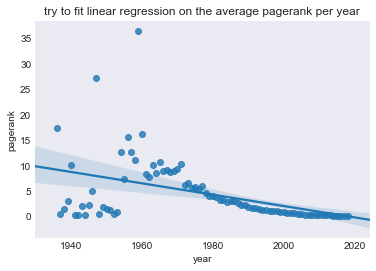

In [313]:
# fitting a regression to see if there is a positive or negative evolution of the citations
fig2 = sns.regplot(x ='year', y = 'pagerank', data = average_year_PR)
fig2 = fig2.set_title('try to fit linear regression on the average pagerank per year')

In [272]:
#extracting the pagerank max for each year, in other terms here we want to extract the most cited publication per year
max_pagerank = page_rank_df.groupby(by ='year').max().sort_values(by = 'pagerank', ascending = False).reset_index()

In [273]:
max_pagerank = max_pagerank['title year pagerank'.split()]

In [333]:
max_pagerank.head()

,title,year,pagerank
0,Unnormalized Floating Point Arithmetic,1959,2018.186268
1,ℓ-matrices and a characterization of binary ma...,1974,1396.062942
2,Über ein Problem von L. Collatz,1971,1364.043082
3,α Logic and Infinitary Languages,1976,1238.157584
4,“Natural” properties of flowchart step-countin...,1978,1015.430039


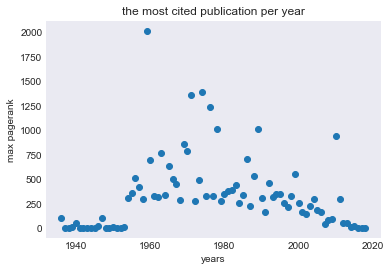

In [334]:
plt.title('the most cited publication per year')
plt.xlabel('years')
plt.ylabel('max pagerank')
fig1 = plt.scatter(x = max_pagerank['year'], y = max_pagerank['pagerank'])

In [275]:
#counting the number of publication per year to be critical towards the average pagerank per year
count_per_yer =  page_rank_df.groupby(by ='year').count()['pagerank']

In [276]:
#merging previous information about the dataset to better describe it
describe = pd.DataFrame(count_per_yer).merge(average_year_PR, left_index = True,right_on = 'year').rename(columns = {'pagerank_x' : 'count per year', 'pagerank_y':'mean page rank'})

In [277]:
describe = max_pagerank.merge(describe,left_on = 'year', right_on='year').sort_values(by = 'year')

In [278]:
describe.head()

,title,year,pagerank,count per year,mean page rank
56,Toward a calculus of concepts,1936,104.223908,7,17.504742
76,The þ-function in λ-K-conversion,1937,2.005421,9,0.443435
72,Third Meeting of the Association for Symbolic ...,1938,7.033757,5,1.568065
66,The Hypothesis That Infinite Classes are Similar,1939,18.096214,9,2.966849
61,The calculus of individuals and its uses,1940,54.292833,6,10.140941


# Insights about the dataset based on the PageRank algorithm

First of all the 10 best ranked publications belong to the years between 1959-1989 except for the 'Reducibility Among Combinatorial Problems' which was published in 2010. 
Which seems to be normal because these papers are old papers and had the time to be cited. On top of that they belong to the area marked by the explosion of the algorithms, automation, cryptography... 
The number of publication per year consolidate this idea. In fact we can see that there is an explosion of the publications starting from the 80's. 
On the other hand, the least ranked publications corresponds mostly to recent publications (between 2015-2018) or unpopular ones. 
Secondly, since the field of computer science is getting older, the major discoveries rarifies due to the hardness of big breakthroughs. So many works just get dilluted in this huge sea of publications and they don't get the interest they would have had 10 or 20 years ago.


# Community detection algorithms

In [353]:
#load the strongly connected file
strongly_connected_components_authors = pd.read_parquet('/Users/nourghaliaabassi/Desktop/parquets/authors_strongly_connected')


In [351]:
#load the lpa algorithm used here for the community detection for the references 
lpa_method_references = pd.read_parquet('/Users/nourghaliaabassi/Desktop/parquets/ref_lpa_first')

In [350]:
#load the lpa algorithm applied to the community detection of the authors 
lpa_method_authors = pd.read_parquet('/Users/nourghaliaabassi/Desktop/parquets/authors_community_detection')

In [366]:
#sort by components to know which are the most connected authors
strongly_connected_components_authors.head()

,id,component
0,Ilya V. Osipov,31
1,Thomas Schuster,0
2,Richard C. H. Connor,0
3,Carlos José Pereira de Lucena,0
4,Kelly A. Lyons,0


The lpa algorithm is used for community detection here we can see the labeling for an author in a specified community corresponding for a specified community. We will show how much communities do we have and on average how many author by community. 

In [369]:
lpa_method_authors.head()

,id,label
0,Ilya V. Osipov,180
1,Thomas Schuster,403
2,Richard C. H. Connor,146867
3,Carlos José Pereira de Lucena,66617
4,Kelly A. Lyons,18646


In [373]:
#here we are printing the most dense communities.
lpa_method_authors.groupby(by = 'label').count().sort_values(by = 'id', ascending = False).head()

,id
label,
12629,855
1686481,715
773960,704
251306,616
33543,543


In [374]:
#here we print the least regroupped authors 
lpa_method_authors.groupby(by = 'label').count().sort_values(by = 'id', ascending = False).tail()

,id
label,
1022485,1
1022466,1
1022462,1
548646,1
480871,1


Here, just to check we are going to print the name of the sigle author of the label 1022485 and we are going to verify if this author have zero component in the strongly connected subgraph dataframe. We will find that it is indeed true :D. 

In [392]:
# getting the author name
lpa_method_authors.loc[1022485,'id']

'M.P. Yu'

In [393]:
# getting the number of components corresponding to the author 'M.P. Yu'
strongly_connected_components_authors.loc[strongly_connected_components_authors['id']== 'M.P. Yu']

,id,component
1022485,M.P. Yu,0


In [399]:
# here we want to show the number of communities that we have depending on the 1729816 distinct authors that we have. 
lpa_method_authors.nunique()

id       1729816
label     255797
dtype: int64

In [411]:
lpa_method_references.head()

,id,label
0,5b912b0f-0430-4b0b-b8ab-d17ddec85ec9,392845
1,da7c74a8-40b7-435a-8016-5d000676be2f,2285708
2,676e1927-2c68-47bd-82a5-2ece9ee7c68b,2664910
3,0b18652d-4468-49cf-afa5-69fe8fc2be6c,2286080
4,b3c15437-925b-4249-9388-81f1ccfb6c2d,2407761


In [414]:
lpa_method_references[lpa_method_references['label'] == 392845]


# Clustering

In this section, we we will try to cluster our document based on their titles, abstract and venue to see if we can group documents about the same topics together.

Let's first start with a sample from our data and apply this to a larger scale if we find good results

In [423]:
import re

path = '/Users/nourghaliaabassi/Downloads/dblp-ref/dblp-ref-0.json'
doc = []
with open(path, 'r') as file:
    for line in file:
        j_content = json.loads(line)
        doc.append(j_content)

doc = pd.DataFrame(doc)
doc.head()


,abstract,authors,id,references,title,venue,year
0,The purpose of this study is to develop a lear...,"[Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...",00127ee2-cb05-48ce-bc49-9de556b93346,"[51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...",Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...,2013
1,This paper describes the design and implementa...,"[Gareth Beale, Graeme Earl]",001c58d3-26ad-46b3-ab3a-c1e557d16821,"[10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...",A methodology for the physically accurate visu...,visual analytics science and technology,2011
2,This article applied GARCH model instead AR or...,"[Altaf Hossain, Faisal Zaman, Mohammed Nasser,...",001c8744-73c4-4b04-9364-22d31a10dbf1,"[2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...","Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence,2009
3,NaN,"[Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...",00338203-9eb3-40c5-9f31-cbac73a519ec,"[8c78e4b0-632b-4293-b491-85b1976675e6, 9cdc54f...",Development of Remote Monitoring and Control D...,,2011
4,NaN,"[Giovanna Guerrini, Isabella Merlo]",0040b022-1472-4f70-a753-74832df65266,NaN,Reasonig about Set-Oriented Methods in Object ...,,1998


In [424]:
# Selecting the columns with which we will work
corpus = doc['abstract,title,venue'.split(',')]

In [425]:
# We are setting the Nan values to the empty string to deal with the columns as columns of string
corpus['abstract'] = corpus['abstract'].apply(lambda x: x if type(x)==type('') else '')
corpus['title'] = corpus['title'].apply(lambda x: x if type(x)==type('') else '')
corpus['venue'] = corpus['venue'].apply(lambda x: x if type(x)==type('') else '')

/Users/nourghaliaabassi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/nourghaliaabassi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/nourghaliaabassi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [426]:
# Concatenating the three columns into one Serie
with_venue = True 
if with_venue:
    agg = corpus[corpus.columns.values[0]]
    for col in corpus.columns.values[1:]:
        agg= agg+' '+corpus[col]
        
else:
    agg = corpus['abstract'] + corpus['title']

In [427]:
# The serie obtained
agg.head()

0    The purpose of this study is to develop a lear...
1    This paper describes the design and implementa...
2    This article applied GARCH model instead AR or...
3     Development of Remote Monitoring and Control ...
4     Reasonig about Set-Oriented Methods in Object...
dtype: object

In [428]:
# We are now selecting the columns that we will only use during this section, which are the ones selected to be
# in our corpus DataFrame, the remaining ones will be deleted (For memory sake)
cols_to_del = doc.columns.difference(corpus.columns)
for col in cols_to_del:
    del(doc[col])
corpus = agg
del(agg)
doc.head()


,abstract,title,venue
0,The purpose of this study is to develop a lear...,Preliminary Design of a Network Protocol Learn...,international conference on human-computer int...
1,This paper describes the design and implementa...,A methodology for the physically accurate visu...,visual analytics science and technology
2,This article applied GARCH model instead AR or...,"Comparison of GARCH, Neural Network and Suppor...",pattern recognition and machine intelligence
3,NaN,Development of Remote Monitoring and Control D...,
4,NaN,Reasonig about Set-Oriented Methods in Object ...,


In [429]:
# A tokenize method that processes data by removing anything but the letters (return a list of the words)
def tokenize_only(text):
    
    tokens = re.sub('[^a-zA-Z]', '' ,text).lower().split()
    return tokens

In [430]:
# Selecting a subset to work with from our corpus
my_corpus = corpus[:20000]

Since we are willing to find topics, we thought TFIDF would be the best Feature extractor to use in this case, since it weights well the important words that are not too rare and hence common to same topics and decreases the weights for too common words and words to specific to the document.


In [433]:
# Embedding our corpus using TFIDF
tfidf_vectorizer = TfidfVectorizer( max_features=200000,
                                    stop_words='english',
                                 use_idf=True, tokenizer=tokenize_only, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(my_corpus) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 1.01 s, sys: 136 ms, total: 1.15 s
Wall time: 1.49 s
(20000, 19999)


It will be too heavy to deal with our TFIDF matrix, so we decided to reduce the dimensionality of our matrix to 1000 using SVD


In [436]:
svd = TruncatedSVD(n_components=1000, n_iter=9)
truncated_tfidf_matrix = svd.fit_transform(tfidf_matrix)


Let's start our clustering process

In [437]:
# A function that creates KMeans and runs it with the specified parameters, this will be handy when we will plot
# the silhouette function to try different K values.

def Kmeans_clusters_labels(X,num_clusters=5, return_k_means_object=False):
    num_clusters = num_clusters

    km = KMeans(n_clusters=num_clusters)
    km.fit(X)

    labels = km.predict(X)
    clusters = km.cluster_centers_
    
    return (np.array(clusters),labels) if not return_k_means_object else (np.array(clusters),labels,km)

In [438]:
#silhouette value for one point
def sil(distance, label): 
    """Returns the silhouette value for a point"""
    b = min(distance[~(distance==distance[label])])
    a = distance[label]
    
    s = (b-a)/max(b,a)
    
    return s


In [ ]:
silhouette = []
for i in tqdm(range(5,20)):
    print('Step number : {} for {} clusters'.format(i-4,i))
    clusters,labels = Kmeans_clusters_labels(truncated_tfidf_matrix,i)
    distances = cdist(truncated_tfidf_matrix,clusters)
    clusters = np.array(clusters)
    labels = np.array(labels)
    si=[]
    for i in range(distances.shape[0]):
        si.append(sil(distances[i,:], labels[i]))
        
    silhouette.append(np.array(si).mean())
    
del(clusters, labels, distances, si, i)

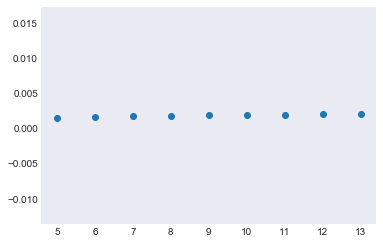

In [445]:
# Plotting the silhouette function to assess the best K to use
plt.scatter(range(5,20), silhouette)

It seems like any value for clustering would give the same result, this is maybe due to the curse of dimensionality, where in such higher dimensions every points seems to be real close to each others, so let's reduce even more the dimensinality of our truncated_tfidf_matrix by applying another time the SVD algorith with n=100


In [446]:
svd = TruncatedSVD(n_components=70, n_iter=9)
truncated_tfidf_matrix = svd.fit_transform(tfidf_matrix)

In [447]:
silhouette = []
for i in tqdm(range(5,20)):
    #print('Step number : {} for {} clusters'.format(i-4,i))
    clusters,labels = Kmeans_clusters_labels(truncated_tfidf_matrix,i)
    distances = cdist(truncated_tfidf_matrix,clusters)
    clusters = np.array(clusters)
    labels = np.array(labels)
    si=[]
    for i in range(distances.shape[0]):
        si.append(sil(distances[i,:], labels[i]))
        
    silhouette.append(np.array(si).mean())
    
del(clusters, labels, distances, si, i)


  0%|          | 0/15 [00:00<?, ?it/s]
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/nourghaliaabassi/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/nourghaliaabassi/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/nourghaliaabassi/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 15/15 [05:34<00:00, 22.31s/it]


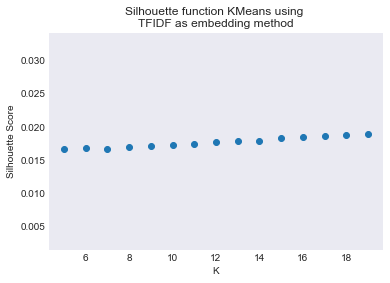

In [448]:
# Plotting the silhouette function to assess the best K to use
plt.scatter(range(5,20), silhouette)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette function KMeans using \nTFIDF as embedding method')
plt.savefig('sil_km_tfidf')

Since the differences are not really big, we decide to choose K=8 because it seems like it has the lowest value

In [449]:
# This variable will contain our best K found.
NUM_CLUSTERS = 8


In [450]:
# So let's now produce the model we think is the more appropriate (Kmeans with K=8)
_, labels,km = Kmeans_clusters_labels(truncated_tfidf_matrix, num_clusters=NUM_CLUSTERS, return_k_means_object=True)

In [451]:
# Let's create a DataFrame containing the documents with their predictions
labeled_docs = pd.DataFrame({'abstract':my_corpus, 'label':labels})

In [452]:
# Let's see how many document per cluster we have
# It seems like they are uniformly distributed upon the 8 clusters
labeled_docs.groupby('label').count()

,abstract
label,
0,2795
1,2860
2,2974
3,2917
4,2868
5,2703
6,2881
7,2


In [453]:
grouped_by_label = labeled_docs.groupby(by='label')

In [454]:
for abstract in grouped_by_label.apply(lambda x: x.loc[x['label']==6, 'abstract']).head(3):
    print("--"+abstract+'\n\n')

-- Software Evolution through Transformations. Electronic Notes in Theoretical Computer Science


--Spatial encryption is a generic public-key cryptosystem where vectors play the role of public keys and secret keys are associated to affine spaces. Any secret key associated to a space can decrypt all ciphertexts encrypted for vectors in that space, and the delegation relation is defined by subspace inclusion. Though several constructions of spatial encryption schemes have been proposed in the literature, none of them are known to remain secure in the leakage-resilient setting, in which the adversary may be capable of learning limited additional information about the master secret key and other secret keys in the system. In this paper, we propose the first spatial encryption scheme achieving leakage resilience in the standard model, based on existing static assumptions over bilinear groups of composite order. Our new scheme is based on the leakageresilient HIBE scheme by Lewko, Rouselaki

In [455]:
for abstract in grouped_by_label.apply(lambda x: x.loc[x['label']==4, 'abstract']).head(3):
    print("--"+abstract+'\n\n')

--This paper focuses on knowledge engineering for the development of a system that provides affective interaction in mobile devices. The system bases its inferences about users' emotions on user input evidence from the keyboard and the microphone of the mobile device. For this purpose different experimental studies have been conducted with the participation of mobile users and human experts. The experiments' aim was twofold. They aimed at revealing the criteria that are taken into account in each mode for emotion recognition as well as their weight of importance. The results of the studies are further used for the application of a multi-criteria decision making model. Knowledge Engineering for Affective Bi-Modal Interaction in Mobile Devices joint conference on knowledge-based software engineering


-- Design of an audio-visual speech corpus for the czech audio-visual speech synthesis. conference of the international speech communication association


--Embedded systems often have limi

It seems like Kmeans did a good job clustering texts with similar words
For cluster 4, the first and third document have the network theme in them, even if it is not written as network in the third document and we DID NOT do any stemming. The second document is about web which is often related to the word network. We are of course speculating, but there is a kind of coherence in this clustering.

Let's move now to another method of word embedding, gloVe. We will use pre-trained glove-vectors on Wikipedia to give to each document a vector representation that we will use to cluster using KMeans

In [456]:
# Method for loading a text file in a DataFrame (each row corresponds to a line)
def load_data(path):
    with open(path) as file:
        words_file = pd.DataFrame([line.rstrip() for line in file])
    return words_file

In [460]:
# Method to load glove vectors from glove.6B, which is a file from stanford containing pre-trained glove vectors on
# wikipedia, which is more appropriate in our case than twitter glove vectors even if it contains less than for twitter.
def load_glove(n=100):
    """Loading glove vectors
    n is the dimension of the vectors, can be 50, 100, 200 or 300"""
    path = 'glove.6B.{}d.txt'.format(n)
    glove_vectors_100 = load_data(path)
    glove_vectors_100[0] = glove_vectors_100[0].apply(lambda x : x.split(' ',1))
    words = pd.DataFrame(glove_vectors_100[0].apply(lambda x : x[0]))
    words['Vectors']= glove_vectors_100[0].apply(lambda x : x[1])
    del(glove_vectors_100)
    words.rename(columns={0:'Words'},inplace=True)
    words['Words'] = words.apply(lambda x : [elem.replace('<','').replace('>','') for elem in x ])
    words.set_index('Words',inplace=True)
    return words


In [461]:
words_glove = load_glove().to_dict()['Vectors']

In [462]:
# As we can see it is still in string format so we will have to process this string (we took hope as an example)
words_glove['hope'][0:18]

'0.034877 0.46079 0'

In [463]:
# Now we are transforming every string a list of floats
for word,vect in words_glove.items():
    words_glove[word] = list(map(lambda x : float(x),(words_glove[word].split())))

In [464]:
words_glove['hope'][0:2]

[0.034877, 0.46079]

In [465]:
# Transforms a given text into a vector of dimension equal to glove vector's dimension by averaging the vectors 
# of each word, or by summing all vectors and normalizing the final vector (We can also return it as matrix)
def vector_representation(text, words_glove, normalized=False):
    splitted_text = text.split()
    vectors = []
    for word in splitted_text:
        vect = words_glove.get(word)
        
        if vect is not None:
            vectors.append(np.array(vect))
            #print(vect)
    #print(np.array(vectors)[0:10])
    vectors = np.array(vectors)
    return vectors.sum(axis=0)/len(vectors) if not normalized else vectors.sum(axis=0)/np.linalg.norm(vectors)

In [466]:
# importing stop-words that we will remove
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [467]:
# removes stopwords from a text
def remove_stopwords(text,stop_words):
    words = text.split()
    for i,word in enumerate(words):
        if stop_words.__contains__(word):
            words[i] = ''
    return ' '.join(words)
# removes punctuation, keeps only alphabet characters
def remove_punc_num(tweet):
    return re.sub('[^a-zA-Z ]', '' ,tweet).lower()

In [468]:
# Let's define our variable for the vector's dimension
VECT_DIM = len(words_glove['hope'])
VECT_DIM

100

In [469]:
# We will create a matrix X_glove containing in each row the corresponding vector (a mapping from each text to a vector)
X_glove = np.zeros((my_corpus.shape[0],VECT_DIM))
for i,text in enumerate(my_corpus):
    vect = vector_representation(remove_punc_num(remove_stopwords(text, stop_words)), words_glove)
    if np.isnan(vect).any():
        X_glove[i,:] = np.zeros(VECT_DIM)
    else:
        X_glove[i,:]=vect

/Users/nourghaliaabassi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [470]:
silhouette_glove_len = []
for i in range(5,20):
    #print('Step number : {} for {} clusters'.format(i-4,i))
    clusters,labels = Kmeans_clusters_labels(X_glove,i)
    distances = cdist(X_glove,clusters)
    clusters = np.array(clusters)
    labels = np.array(labels)
    si=[]
    for i in range(distances.shape[0]):
        si.append(sil(distances[i,:], labels[i]))
        
    silhouette_glove_len.append(np.array(si).mean())
    
del(clusters, labels, distances, si, i)

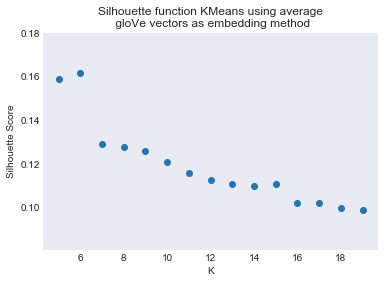

In [471]:
# This is the silhouette function we find when we represent using One glove vector representing the average of all
# glove vectors
plt.scatter(range(5,20), silhouette_glove_len)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette function KMeans using average\n gloVe vectors as embedding method')
plt.savefig('sil_km_gloVe_avg')

From the silhouette plot, we will choose K=7

In [472]:
_, labels_glove,km_glove = Kmeans_clusters_labels(X_glove, num_clusters=7, return_k_means_object=True)

In [473]:
if not dir().__contains__('labeled_docs'):
    labeled_docs = pd.DataFrame({'abstract':my_corpus, 'label_glove':labels_glove})
else:
    labeled_docs['label_glove'] = labels_glove

In [474]:
grouped_glove = labeled_docs.groupby(by='label_glove')
grouped_glove.count()

,abstract,label
label_glove,,
0,3192,3192
1,2052,2052
2,5084,5084
3,218,218
4,424,424
5,5577,5577
6,3453,3453


There is an interesting category as we can see, the one with little number of points/cluster.
So let's check why ! 

In [475]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove']==5, 'abstract']).head(5):
    print(abstract+'\n\n')

 COMPARING GNG3D AND QUADRIC ERROR METRICS METHODS TO SIMPLIFY 3D MESHES international conference on computer graphics theory and applications


 Vectorial fast correlation attacks. 


Recent achievements in Natural Language Processing (NLP) and Psychology invoke the challenges to identify the insight of emotions. In the present study, we have identified different psychology related theme words while analyzing emotions on the interview data of ISEAR (International Survey of Emotion Antecedents and Reactions) research group. Primarily, we have developed a Graphical User Interface (GUI) to generate visual graphs for analyzing the impact of emotions with respect to different background, behavioral and physiological variables available in the ISEAR dataset. We have discussed some of the interesting results as observed from the generated visual graphs. On the other hand, different text clusters are identified from the interview statements by selecting individual as well as different combina

In [476]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove']==3, 'abstract']).head(5): 
    print(abstract+'\n\n')

 Aprendizaje de Sistemas Digitales Utilizando Tecnologías Interactivas. Revista Iberoamericana De Tecnologías Del Aprendizaje


Les donnees temporelles peuvent etre traitees de nombreuses facons afin d'en extraire des connaissances. La decouverte de motifs sequentiels met en evidence des sous-sequences frequentes contenues dans des sequences d'enregistrements annotes temporellement. L'analyse des acces a un site web permet par exemple de decouvrir que "5% des utilisateurs accedent a la page register.php puis a la page help.html". Cependant, les motifs sequentiels ne permettent pas d'extraire des tendances temporelles, du type "une augmentation du nombre de requetes au formulaire d'inscription precede souvent une augmentation des requetes a la page d'aide quelques secondes plus tard". Dans cet article, nous proposons d'extraire des motifs caracterisant ces evolutions frequentes grâce a deux algorithmes, TED et EVA. Nous presentons notre approche, implementee et testee sur des donnees re

As we can see for the cluster 5, glove regroupped texts with similar semantics, here we can see 4 french texts and one in spanish (the 1st one).     
In the cluster 3, KMeans regrouped German documents.  
So using glove can be handy if we want to verify if communities using the same language tend to work with each other most, to cite from works written in their language.
So the low number of points/cluster was due to the fact that there is small number of documents not written in english, which suggests that glove vectors for different languages are far away from each other.
Let's see now if normalizing the vector gives better results than averaging

In [477]:
X_glove = np.zeros((my_corpus.shape[0],VECT_DIM))
for i,text in enumerate(my_corpus):
    vect = vector_representation(remove_punc_num(remove_stopwords(text, stop_words)), words_glove, normalized=True)
    if np.isnan(vect).any():
        X_glove[i,:] = np.zeros(VECT_DIM)
    else:
        X_glove[i,:]=vect

/Users/nourghaliaabassi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [478]:
silhouette_glove_norm = []
for i in range(5,20):
    #print('Step number : {} for {} clusters'.format(i-4,i))
    clusters,labels = Kmeans_clusters_labels(X_glove,i)
    distances = cdist(X_glove,clusters)
    clusters = np.array(clusters)
    labels = np.array(labels)
    si=[]
    for i in range(distances.shape[0]):
        si.append(sil(distances[i,:], labels[i]))
        
    silhouette_glove_norm.append(np.array(si).mean())
    
del(clusters, labels, distances, si, i)


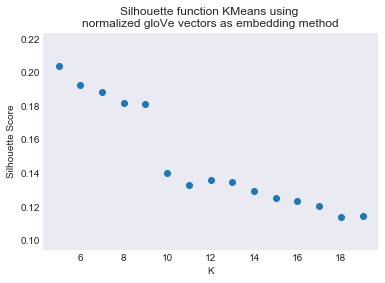

In [479]:
# This is the silhouette function we find when we represent using One glove vector representing the sum of all
# glove vectors normalized to a unit-length vector
plt.scatter(range(5,20), silhouette_glove_norm)
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette function KMeans using \nnormalized gloVe vectors as embedding method')
plt.savefig('sil_km_gloVe_norm')

So let's choose K=11 in this case and see what kind of clustering we obtained

In [480]:
_, labels_glove,km_glove = Kmeans_clusters_labels(X_glove, num_clusters=11, return_k_means_object=True)

In [481]:
if not dir().__contains__('labeled_docs'):
    labeled_docs = pd.DataFrame({'abstract':my_corpus, 'label_glove_norm':labels_glove})
else:
    labeled_docs['label_glove_norm'] = labels_glove

In [482]:
grouped_glove = labeled_docs.groupby(by='label_glove_norm')
grouped_glove.count()

,abstract,label,label_glove
label_glove_norm,,,
0,3809,3809,3809
1,1435,1435,1435
2,1228,1228,1228
3,1251,1251,1251
4,454,454,454
5,609,609,609
6,1516,1516,1516
7,50,50,50
8,1769,1769,1769


As we can see, for some clusters, the points are really small, so let's check what's going on with these clusters

In [483]:
# Let's start with cluster n=10
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_norm']==10, 'abstract']).head(5):
    print(abstract+'\n\n')

 Development of Remote Monitoring and Control Device for 50KW PV System Based on the Wireless Network 


 COMPARING GNG3D AND QUADRIC ERROR METRICS METHODS TO SIMPLIFY 3D MESHES international conference on computer graphics theory and applications


 A Self-Stabilizing Algorithm for Finding the Cutting Center of a Tree. parallel and distributed processing techniques and applications


 Fur Visualisation for Computer Game Engines and Real-Time Rendering international conference on computer vision and graphics


 Simulation of a vision steering system for road vehicles 




In [484]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_norm']==8, 'abstract']).head(5):
    print(abstract+'\n\n')

The purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net- works. More specifically, we focus on the basic principles of network proto- cols as the aim to develop our learning tool. Our tool gives students hands-on experience to help understand the basic principles of network protocols. Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map international conference on human-computer interaction


This paper focuses on knowledge engineering for the development of a system that provides affective interaction in mobile devices. The system bases its inferences about users' emotions on user input evidence from the keyboard and the microphone of the mobile device. For this purpose different experimental studies have been conducted with the participation of mobile users and human experts. The experi

In [485]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_norm']==1, 'abstract']).head(5):
    print(abstract+'\n\n')

Most applications of the abstract interpretation framework[2] have been foranalyzing functional programs use functions on abstract values to approxi-mate functions, thus assuming that functions may be called at all arguments.When the abstract domain is ﬁnite, this approach can easily be generalizedto higher order functional languages as shown for example by [1]. In practicethis leads to combinatorial explosion problems as observed, for example, instrictness analysis of higher order functional languages. Relational Abstract Interpretation of Higher Order Functional Programs (extended abstract) 


Previous language modeling approaches to information retrieval have focused primarily on single terms. The use of bigram models has been studied, but the restriction on word order and adjacency may not be justified for information retrieval. We propose a new language modeling approach to information retrieval that incorporates lexical affinities, or pairs of words that occur near each other, wi

In [486]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_norm']==4, 'abstract']).head(5):
    print(abstract+'\n\n')

Distributed computing systems are of huge importance in a number of recently established and future functions in computer science. For example, they are vital to banking applications, communication of electronic systems, air trafﬁc control, manufacturing automation, biomedical operation works, space monitoring systems and robotics information systems. As the nature of computing comes to be increasingly directed towards intelligence and autonomy, intelligent computations will be the key for all future applications. Intelligent distributed computing will become the base for the growth of an innovative generation of intelligent distributed systems. Nowadays, research centres require the development of architectures of intelligent and collaborated systems; these systems must be capable of solving problems by themselves to save processing time and reduce costs. Building an intelligent style of distributed computing that controls the whole distributed system requires communications that must

In [487]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_norm']==3, 'abstract']).head(5):
    print(abstract+'\n\n')

In recent years, most of mobile phones have a function of pedestrian navigation guidance. It was reported that users sometimes feel anxiety because of low accuracy of the position estimation especially in urban area and delay of information updating. In order to reduce the anxiety, a route planning algorithm is proposed in this study, which weighs user's difficulty (or easiness) of locating own current position as well as total physical distance of courses. The difficulty is estimated by valuation functions based on the "recognizability" and "visibility" of landmarks. An experimental study conducted in real situation using a prototype system to examine and refine the model for the optimal route planning. As the result, a modified model is proposed as a promising method of route planning for user's easy wayfinding. A pedestrian navigation method for user's safe and easy wayfinding international conference on human computer interaction


Business strategy should be well understood in ord

As we can see, it seems like now, the length of the document matters, as we can see, we still clustered the french from the others, but as we can see, in each sample, the length of the documents is either big or small, no documents with substantially different length appears together, so KMeans with gloVe normalized seems to fail clustering by topic but still get you the different languages if they exist.  

For this reason, let's try clustering using K=4 and see if we have 4 different clusters for each language

In [488]:
_, labels_glove,km_glove = Kmeans_clusters_labels(X_glove, num_clusters=4, return_k_means_object=True)

In [489]:
if not dir().__contains__('labeled_docs'):
    labeled_docs = pd.DataFrame({'abstract':my_corpus, 'label_glove_4':labels_glove})
else:
    labeled_docs['label_glove_4'] = labels_glove

In [490]:
grouped_glove = labeled_docs.groupby(by='label_glove_4')
grouped_glove.count()

,abstract,label,label_glove,label_glove_norm
label_glove_4,,,,
0,4972,4972,4972,4972
1,4241,4241,4241,4241
2,7557,7557,7557,7557
3,3230,3230,3230,3230


In [491]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_4']==0, 'abstract']).head(2):
    print(abstract+'\n\n')

 Reasonig about Set-Oriented Methods in Object Databases. 


 Vectorial fast correlation attacks. 




In [492]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_4']==1, 'abstract']).head(2):
    print(abstract+'\n\n')

The purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net- works. More specifically, we focus on the basic principles of network proto- cols as the aim to develop our learning tool. Our tool gives students hands-on experience to help understand the basic principles of network protocols. Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map international conference on human-computer interaction


This article applied GARCH model instead AR or ARMA model to compare with the standard BP and SVM in forecasting of the four international including two Asian stock markets indices.These models were evaluated on five performance metrics or criteria. Our experimental results showed the superiority of SVM and GARCH models, compared to the standard BP in forecasting of the four international stock marke

In [493]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_4']==2, 'abstract']).head(2):
    print(abstract+'\n\n')

 Development of Remote Monitoring and Control Device for 50KW PV System Based on the Wireless Network 


 COMPARING GNG3D AND QUADRIC ERROR METRICS METHODS TO SIMPLIFY 3D MESHES international conference on computer graphics theory and applications




In [494]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_4']==3, 'abstract']).head(2):
    print(abstract+'\n\n')

This paper describes the design and implementation of a methodology for the visualisation and hypothetical virtual reconstruction of Roman polychrome statuary for research purposes. The methodology is intended as an attempt to move beyond visualisations which are simply believable towards a more physically accurate approach. Accurate representations of polychrome statuary have great potential utility both as a means of illustrating existing interpretations and as a means of testing and revising developing hypotheses. The goal of this methodology is to propose a pipeline which incorporates a high degree of physical accuracy whilst also being practically applicable in a conventional archaeological research setting. The methodology is designed to allow the accurate visualisation of surviving objects and colourants as well as providing reliable methods for the hypothetical reconstruction of elements which no longer survive. The process proposed here is intended to limit the need for specia

In [495]:
X_glove = np.zeros((my_corpus.shape[0],VECT_DIM))
for i,text in enumerate(my_corpus):
    vect = vector_representation(remove_punc_num(remove_stopwords(text, stop_words)), words_glove)
    if np.isnan(vect).any():
        X_glove[i,:] = np.zeros(VECT_DIM)
    else:
        X_glove[i,:]=vect

/Users/nourghaliaabassi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


In [496]:
_, labels_glove,km_glove = Kmeans_clusters_labels(X_glove, num_clusters=4, return_k_means_object=True)

In [497]:
if not dir().__contains__('labeled_docs'):
    labeled_docs = pd.DataFrame({'abstract':my_corpus, 'label_glove_4_avg':labels_glove})
else:
    labeled_docs['label_glove_4_avg'] = labels_glove

In [498]:
grouped_glove = labeled_docs.groupby(by='label_glove_4_avg')
grouped_glove.count()

,abstract,label,label_glove,label_glove_norm,label_glove_4
label_glove_4_avg,,,,,
0,5807,5807,5807,5807,5807
1,9172,9172,9172,9172,9172
2,4376,4376,4376,4376,4376
3,645,645,645,645,645


In [499]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_4_avg']==0, 'abstract']).head(2):
    print(abstract+'\n\n')

The purpose of this study is to develop a learning tool for high school students studying the scientific aspects of information and communication net- works. More specifically, we focus on the basic principles of network proto- cols as the aim to develop our learning tool. Our tool gives students hands-on experience to help understand the basic principles of network protocols. Preliminary Design of a Network Protocol Learning Tool Based on the Comprehension of High School Students: Design by an Empirical Study Using a Simple Mind Map international conference on human-computer interaction


 Development of Remote Monitoring and Control Device for 50KW PV System Based on the Wireless Network 




In [500]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_4_avg']==2, 'abstract']).head(2):
    print(abstract+'\n\n')

 Reasonig about Set-Oriented Methods in Object Databases. 


Recently, Bridges and Reich introduced the concept of multisymplectic spectral discretizations for Hamiltonian wave equations with periodic boundary conditions [5]. In this paper, we show that the ID nonlinear Schrodinger equation and the 2D Gross-Pitaevskii equation are multi-symplectic and derive multi-symplectic spectral discretizations of these systems. The effectiveness of the discretizations is numerically tested using initial data for multi-phase solutions. Multisymplectic Spectral Methods for the Gross-Pitaevskii Equation international conference on conceptual structures




In [501]:
for abstract in grouped_glove.apply(lambda x: x.loc[x['label_glove_4_avg']==3, 'abstract']).head(2):
    print(abstract+'\n\n')

 HyperScout: Linkvorschau im World Wide Web. Zeitschrift Für Interaktive Und Kooperative Medien


 Aprendizaje de Sistemas Digitales Utilizando Tecnologías Interactivas. Revista Iberoamericana De Tecnologías Del Aprendizaje




We still were able to find German documents, so this method would work better, but as we can see, sensitivity to length is still present for this reason we decided to not use gloVe with our clustering algorithm (KMeans).




















